# Initialisation 

In [ ]:
!pip install XGBoost==1.5.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import xgboost as xgb
import tensorflow as tf
from gc import collect
import pandas as pd
import os
from time import time
from gc import collect as delete

In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"

In [ ]:
!wget --no-check-certificate -r "https://docs.google.com/uc?export=download&id=1RlvdtcHKFu8RQ5Tv7IAhRDeGBW3QNwOH" -O "Weights.zip"

In [ ]:
!gzip -d HIGGS.csv.gz

In [ ]:
!unzip Weights.zip

# Refining the data

In [ ]:
def refine_data():
    # Step 1: 
    df = pd.read_csv("HIGGS.csv", header = None)

    data_set = np.array(df.iloc[:, 1:])
    label_set = np.array(df.iloc[:, 0])

    # Getting rid of unnecessary data from RAM to
    # accomodate within the 12GB RAM provided by Colab
    del df
    delete()

    data_set = np.round(data_set, 5)

    data_set = data_set.astype(np.float32)
    label_set = label_set.astype(np.int32)

    df_data_set = pd.DataFrame(data_set)
    df_label_set = pd.DataFrame(label_set)

    s = df_data_set.min()
    l = df_data_set.max()

    # Step 2: Normalization
    normed_df_Data_set = ((df_data_set - s) / (l - s)).astype(np.float32)

    # Saving data to file
    df_label_set.to_csv("LabelSet.csv")
    normed_df_Data_set.to_csv("DataSetNormalised.csv")

# All the Models
## * These are the functions only.

There are 6 models in our machine Learning Pipeline. We have put them in functions and the functions are here. We didn't call them here. they will be called later.

#### Deep Neural Network DNN5 

In [ ]:
def DNN5_fc():
    '''Deep Neural Network DNN5'''
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(300, input_shape=(28,), activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(
        learning_rate = 0.01,
        beta_1 = 0.9,
        beta_2 = 0.999),
        loss = 'binary_crossentropy',
        metrics = ['accuracy','AUC']
        )
    model.fit(
        x_train,
        y_train,
        epochs=1,
        batch_size=10240,
        validation_data=(x_test,y_test)
    )
    model.save('DNN_5')

#### Resnet 52 custom model

In [ ]:
def identity_block(X, no_nodes, Activation):
    '''A custom Residual identity block with a skip connection'''
    # This function is not to be called manually, it will be used by RN52_fc() function
    X_shortcut=X
    # There will be 3 layers in total for the sequential connection
    # Activation will be specified by the user as per the Keras Documentation
    # no_nodes denote the size of the model which will be built
    # Applying Batch Normalisation to size the inputs
    
    #Layer 1
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.BatchNormalization(axis=1)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 2
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.BatchNormalization(axis=1)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 3
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 4
    X= tf.keras.layers.Add()([X_shortcut, X])
    X=tf.keras.layers.Activation('relu')(X)

    X_shortcut2=X
    #Layer 5
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.BatchNormalization(axis=1)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 6
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.BatchNormalization(axis=1)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 7
    X=tf.keras.layers.Dense(no_nodes,activation=Activation)(X)
    X=tf.keras.layers.Dropout(d_rate)(X)

    #Layer 8
    X = tf.keras.layers.Add()([X_shortcut, X,X_shortcut2])
    X = tf.keras.layers.Activation('relu')(X)
    return X

def RN52_fc():
    '''Resnet 52'''
    d_rate=0.1 #The rate of droupout for the layers in the ResNet
    act='gelu'#The activation function use ('relu','swish','elu','gelu','selu')
    lr=0.01 #The default learning rate Default 0.01
    mom=0.9 #The momentum parameter Default 0.9
    test_split=1 #Default 1 and range[1,0)
    #Reducing test_split will make the model faster but will also reduce the accuracy of the Validation metric
    #On changing test_split run the lower initialisation cell, marked below**
    
    inputs=tf.keras.layers.Input(shape=(28,))                    #Keras input layer
    X=tf.keras.layers.Dense(300,activation=act)(inputs)
    X=identity_block(X=X,no_nodes=300,Activation=act)
    X=identity_block(X=X,no_nodes=300,Activation=act)
    X=identity_block(X=X,no_nodes=300,Activation=act)
    X=identity_block(X=X,no_nodes=300,Activation=act)
    X=identity_block(X=X,no_nodes=300,Activation=act)        
    outputs=tf.keras.layers.Dense(1,activation='sigmoid')(X)     #keras output layer
    model=tf.keras.Model(inputs,outputs)#Model declaration
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
        beta_1=mom,
        beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                 factor=0.5,
                                                 patience=5,
                                                 min_lr=10**-6,
                                                 cooldown=5,
                                                 verbose = True)

    history = History()

    model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=20000,
        validation_data=(x_test,y_test),
        callbacks=[cp_callback, reduce_lr, history]
    )
    model.save('ResNet_52')

    with open("hstory.txt", "w") as f:
        f.write(str(history.history))

#### XG Boost

In [ ]:
def XGB_fc():
    '''XG Boost'''
    model = XGBClassifier(tree_method='gpu_hist',
                          booster = 'gbtree',
                          max_depth = 14,
                          n_estimators = 300,
                          learning_rate = 0.4,
                          reg_lambda=600
                         )

    eval_set = [(x_test_alpha, y_test_alpha)]

    t0 = time()
    a = model.fit(x_train_alpha,
              y_train_alpha,
              eval_metric="error",
              eval_set=eval_set,
              verbose=True)
    taken = time()-t0

    y_test_alpha_pred = model.predict(x_test_alpha,ntree_limit=model.best_ntree_limit)
    accuracy_test = accuracy_score(y_test_alpha, y_test_alpha_pred)
    print("The testing accuracy", accuracy_test*100)

    y_train_alpha_pred=model.predict(x_train_alpha,ntree_limit=model.best_ntree_limit)
    accuracy_train = accuracy_score(y_train_alpha, y_train_alpha_pred)
    print("The training accuracy", accuracy_train*100)
    model.save_model("XGBoost.json")

#### Shallow Neural Network 1024 levels deep

In [ ]:
def S1024_fc():
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(1024,input_shape=(28,),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128,activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
        )
    
    model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=10240,
        validation_data=(x_test,y_test),
        callbacks=[cp_callback]
        )
    
    model.save('NN_Shallow_1024')

#### Shallow Neural Network 2048 levels deep

In [ ]:
def S1024_fc():
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(1024,input_shape=(28,),activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128,activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
        )
    
    model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=10240,
        validation_data=(x_test,y_test),
        callbacks=[cp_callback]
        )
    
    model.save('NN_Shallow_1024')

#### Shallow Neural Network 10240 levels deep

In [ ]:
def S10240_fc():
    model=tf.keras.Sequential([
    tf.keras.layers.Dense(10240,input_shape=(28,),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
                            learning_rate=0.001,
                            beta_1=0.9,
                            beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC']
    )
    
    model.fit(
        x_train,
        y_train,
        epochs=10,
        batch_size=10240,
        callbacks=[cp_callback]
    )

    model.save('NN_Shallow_2048')

# Ensemble (function only)

In [ ]:
def ens_fc(x_test):
    print("starting")
    # Loading the models:
    #    XG Boost
    model_xgb = XGBClassifier()
    model_xgb.load_model("XGBoost.json")
    y_test_pred_xgb = model_xgb.predict_proba(x_test)
    y_pred_xgb = y_test_pred_xgb[:,1]
    y_test_pred_xgb = np.reshape(y_pred_xgb,(1_00_000,1))
    print("\n\n1.1 Loaded XGBoost\n\n")

    #    DNN 5
    model_DNN_5 = tf.keras.models.load_model('DNN_5')
    y_test_pred_DNN_5 = model_DNN_5.predict(x_test)
    print("\n\n2.1 Loaded DNN 5\n\n")

    #    Shallow 1024
    model_NN_Shallow_1024 = tf.keras.models.load_model('NN_Shallow_1024')
    y_test_pred_NN_Shallow_1024 = model_NN_Shallow_1024.predict(x_test)
    print("\n\n3.1 Loaded Shallow 1024\n\n")

    #    Shallow 2048
    model_NN_Shallow_2048 = tf.keras.models.load_model('NN_Shallow_2048')
    y_test_pred_NN_Shallow_2048 = model_NN_Shallow_2048.predict(x_test)
    print("\n\n4.1 Loaded Shallow 2048\n\n")

    #    Shallow 10240
    model_NN_Shallow_10240 = tf.keras.models.load_model('NN_Shallow_10240')
    y_test_pred_NN_Shallow_10240 = model_NN_Shallow_10240.predict(x_test)
    print("\n\n5.1 Loaded Shallow 10240\n\n")

    #    ResNet 52
    model_ResNet_52 = tf.keras.models.load_model('ResNet_52')
    y_test_pred_model_ResNet_52 = model_ResNet_52.predict(x_test)
    print("\n\n6.1 Loaded ResNet 52\n\n")


    # # The below code is used to find the fine-tuned values for ensembling all the models
    # for i in range(10000):
    #     pre=(np.random.rand(6,1))
    #     y_pred_ensemble=y_test_pred_DNN_5*pre[0]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_model_ResNet_52*pre[1]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_NN_Shallow_1024*pre[2]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_NN_Shallow_10240*pre[3]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_NN_Shallow_2048*pre[4]
    #     y_pred_ensemble=y_pred_ensemble+y_test_pred_xgb*pre[5]
    #     y_pred_ensemble=y_pred_ensemble/(pre[0]+pre[1]+pre[2]+pre[3]+pre[4]+pre[5])
    #     fpr, tpr, thresholds = roc_curve(y_test, y_pred_ensemble)
    #     auc=metrics.auc(fpr, tpr)
    #     if auc>auc_max:
    #         auc_max=auc
    #         print("New Max detected")
    #         print("Auc",auc)
    #         print("--------------------------------------------")
    #         pre_max=pre
    #     if i%1000==0:
    #         print(str(i))

    pre = (0.9874, 0.5109, 0.4046, 0.00178, 0.18467, 0.17939) # Calculated by finetuning

    y_pred_ensemble = y_test_pred_DNN_5*pre[0]
    print("1.2 Added XGBoost")
    y_pred_ensemble += y_test_pred_model_ResNet_52*pre[1]
    print("2.2 Added DNN 5")
    y_pred_ensemble += y_test_pred_NN_Shallow_1024*pre[2]
    print("3.2 Added Shallow 1024")
    y_pred_ensemble += y_test_pred_NN_Shallow_10240*pre[3]
    print("4.2 Added Shallow 2048")
    y_pred_ensemble += y_test_pred_NN_Shallow_2048*pre[4]
    print("5.2 Added Shallow 10240")
    y_pred_ensemble += y_test_pred_xgb*pre[5]
    print("6.2 Added ResNet 52")

    y_pred_ensemble /= sum(pre)
    # ntgt() # Used for fine tuning of model, @Aritra don't uncomment it
    return y_pred_ensemble

# Calling the functions Sequentially

In [ ]:
# Refining the data!
refine_data()

In [ ]:
# Importing the dataset
df_data = pd.read_csv("DataSetNormalised.csv")
df_label = pd.read_csv("LabelSet.csv")

In [ ]:
# Separating the data
x = np.array(df_data.iloc[:,1:])
y = np.array(df_label.iloc[:,1])
x = x.astype(np.float32)
x_train = x[:][:1_00_00_000]
y_train = y[:][:1_00_00_000]
x_test = x[:][-1_00_000:]
y_test = y[:][-1_00_000:]

In [ ]:
# # Calling the models for training
# #       This has been intensionally commented out because
# #       we have already trained them and downloaded the weights
# #       from Google Drive. See Initialization part.
# #       Note: As you are not running this block, the next block
# #             will throw a number of warnings, please ignore them!
# DNN5_fc()
# RN52_fc()
# XGB_fc()
# S1024_fc()
# S2048_fc()
# S10240_fc()

In [ ]:
# Caling the ensemble
# Send the data set X (After normalisation min-max)
# keep y_test as the testing data set
y_pred = ens_fc(x_test) # takes around 3 minutes

starting


1.1 Loaded XGBoost






2.1 Loaded DNN 5






3.1 Loaded Shallow 1024






4.1 Loaded Shallow 2048






5.1 Loaded Shallow 10240




6.1 Loaded ResNet 52


1.2 Added XGBoost
2.2 Added DNN 5
3.2 Added Shallow 1024
4.2 Added Shallow 2048
5.2 Added Shallow 10240
6.2 Added ResNet 52


# Finally Some Nice looking Curves

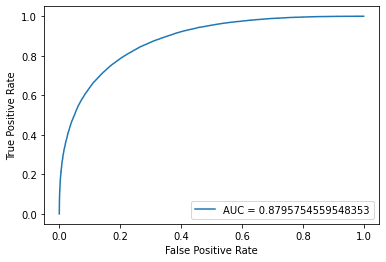

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr, tpr, label="AUC = " + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()